In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define the transition rate matrix
Lambda_open = np.array([
    [0, 0.75, 0.75,    0,   0],
    [0,    0, 0.25, 0.25, 0.5],
    [0,    0,    0,  1.0,   0],
    [0,    0,    0,    0, 1.0],
    [0,    0,    0,    0, 1.0]
])

---
---
---

### 3.Exercise-a

* Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time with input rate $λ$ = 100.

* What is the largest input rate that the system can handle without blowing up?

In [4]:

# Compute cumulative transition probabilities for transitions
Q_cum = np.cumsum(Lambda_open / Lambda_open.sum(axis=1, keepdims=True), axis=1)

# Number of nodes (excluding dummy input node)
num_nodes = Lambda_open.shape[0]
dummy_node = num_nodes


In [5]:

def get_starting_node(node_particles, input_rate):
    """
    Choose the starting node for the next event based on current particles and input rate.
    """
    total_particles = input_rate + np.sum(node_particles)
    probabilities = np.append(node_particles, input_rate) / total_particles
    return np.random.choice(range(dummy_node + 1), p=probabilities), total_particles


In [6]:

def simulate_proportional_rate(time_units, input_rate):
    """
    Simulate the particle dynamics with proportional rates.
    """
    node_particles = np.zeros(num_nodes)  # Initialize particles in each node
    transition_times = [0]
    history = [node_particles.copy()]
    
    
    while True:
        # Get starting node and calculate time to next event
        start_node, total_particles = get_starting_node(node_particles, input_rate)
        t_next = transition_times[-1] - np.log(np.random.rand()) / total_particles

        # Handle events
        if start_node == dummy_node:  # External input (dummy node)
            node_particles[0] += 1  # Add to node 'o'
        elif start_node == num_nodes - 1:  # Node 'd' (absorbing state)
            node_particles[-1] -= 1
        else:
            end_node = np.argwhere(Q_cum[start_node] > np.random.rand())[0][0]
            node_particles[start_node] -= 1
            node_particles[end_node] += 1

        # Record state and time
        transition_times.append(t_next)
        history.append(node_particles.copy())

        # Stop simulation if time exceeds limit
        if t_next > time_units:
            break

    return np.array(history), np.array(transition_times)

In [7]:

def plot_trajectories(transition_times, history, input_rate):
    """
    Plot the particle dynamics over time.
    """
    labels = ['o', 'a', 'b', 'c', 'd']
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(labels):
        plt.plot(transition_times, history[:, i], label=f"Node {label}",linewidth=0.7)

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Number of Particles")
    plt.title(f"Proportional Rate Simulation (Input rate = {input_rate})")
    plt.grid()
    plt.savefig(f"proportional_rate_simulation_{input_rate}.jpg")
    plt.show()


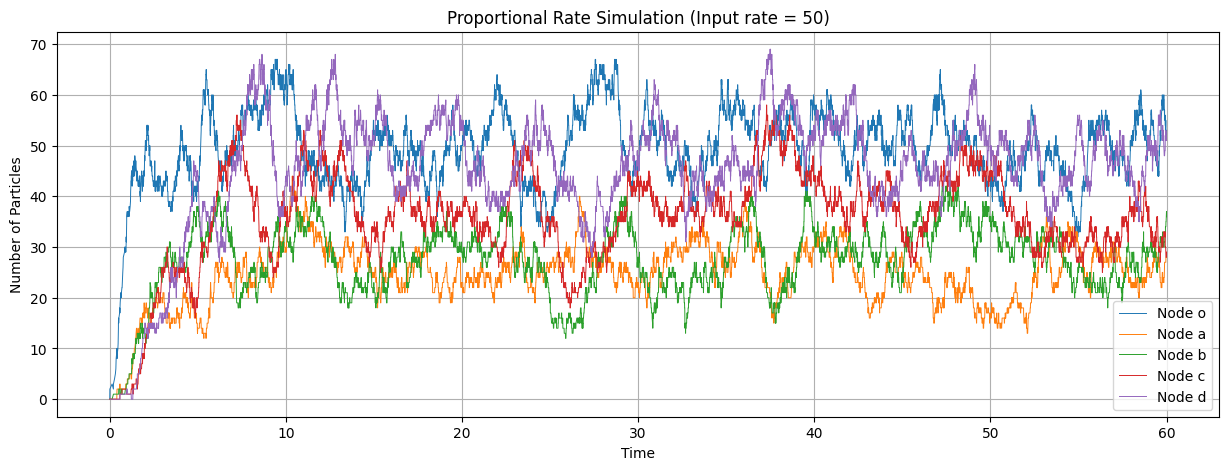

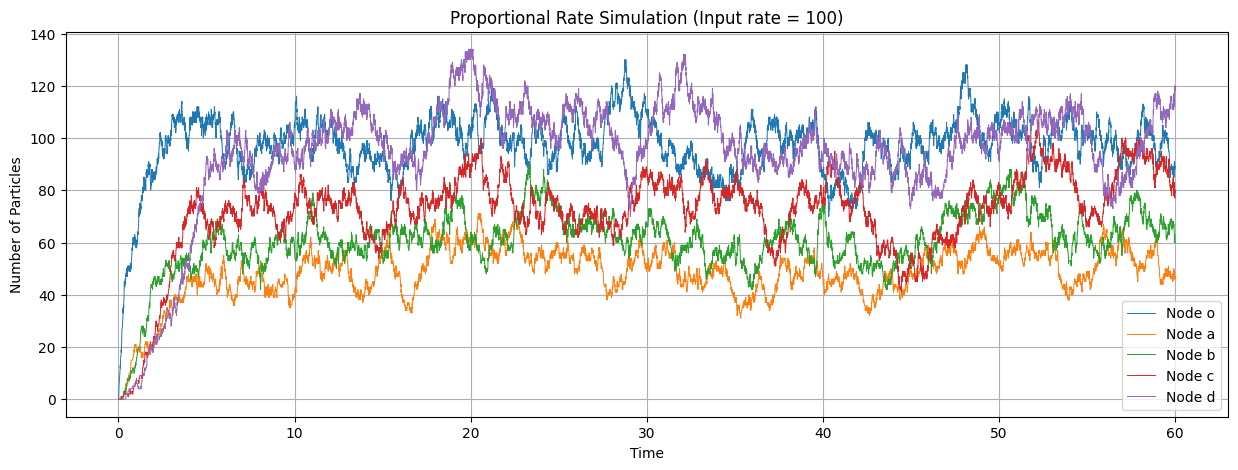

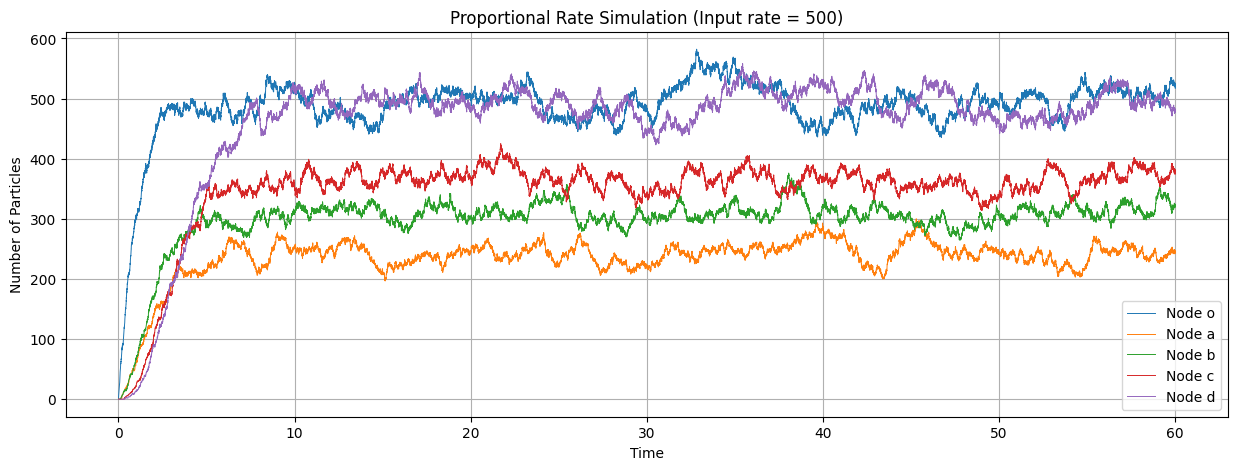

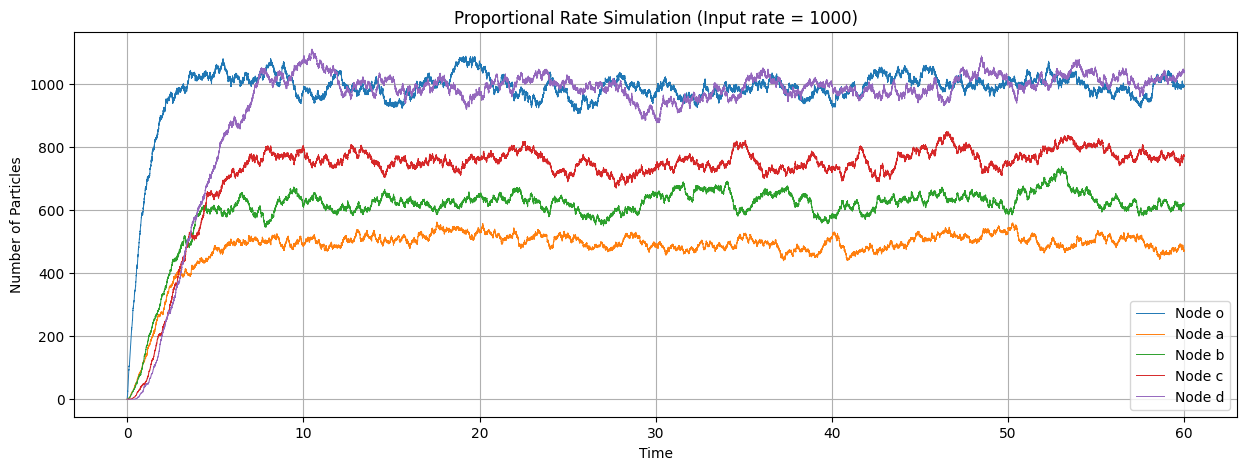

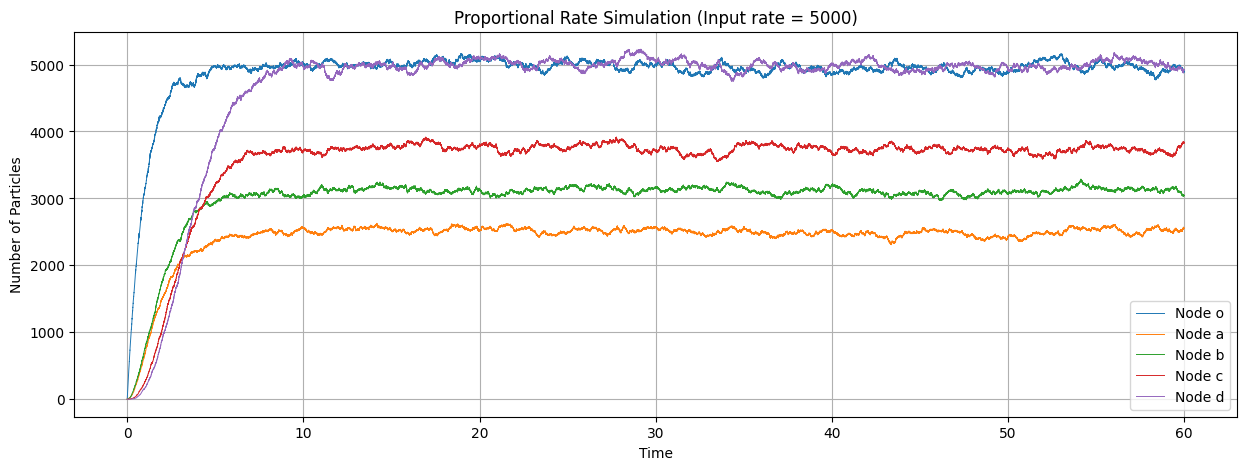

In [8]:
# Run simulation and plot
input_rates = [50, 100, 500, 1000, 5000]
time_units = 60

for rate in input_rates:
    history, transition_times = simulate_proportional_rate(time_units, rate)
    plot_trajectories(transition_times, history, rate)


### 3.Exercise-b

* Simulate the system for 60 time units and plot the evolution of number of particles in each node over time with input rate $λ$ = 1.

* What is the largest input rate that the system can handle without blowing up? Motivate your answer.

In [9]:
# Fixed rates for each node
def fixed_rate_simulation(time_units, input_rate):
    """
    Simulate the particle dynamics with fixed rates.
    """
    node_particles = np.zeros(num_nodes)  # Initialize particles in each node
    transition_times = [0]
    history = [node_particles.copy()]

    # Initialize fixed rates for each node
    fixed_rates = Lambda_open.sum(axis=1)
    fixed_rates[-1] = 2  # Special case for node 'd'

    while True:
        # Total rate of the system
        total_rate = input_rate + fixed_rates.sum()

        # Time to next event
        t_next = transition_times[-1] - np.log(np.random.rand()) / total_rate

        # Decide which node or input contributes the next event
        probabilities = np.append(fixed_rates, input_rate) / total_rate
        selected_node = np.random.choice(range(num_nodes + 1), p=probabilities)

        if selected_node == num_nodes:  # Input event
            node_particles[0] += 1
        elif selected_node == num_nodes - 1:  # Node 'd'
            if node_particles[-1] > 0:
                node_particles[-1] -= 1  # Remove particle from node 'd'
        else:
            # Choose destination based on transition probabilities
            transition_probs = Lambda_open[selected_node] / fixed_rates[selected_node]
            end_node = np.random.choice(range(num_nodes), p=transition_probs)
            if node_particles[selected_node] > 0:
                node_particles[selected_node] -= 1
                node_particles[end_node] += 1

        # Record state and time
        transition_times.append(t_next)
        history.append(node_particles.copy())

        # Stop simulation if time exceeds limit
        if t_next > time_units:
            break

    return np.array(history), np.array(transition_times)


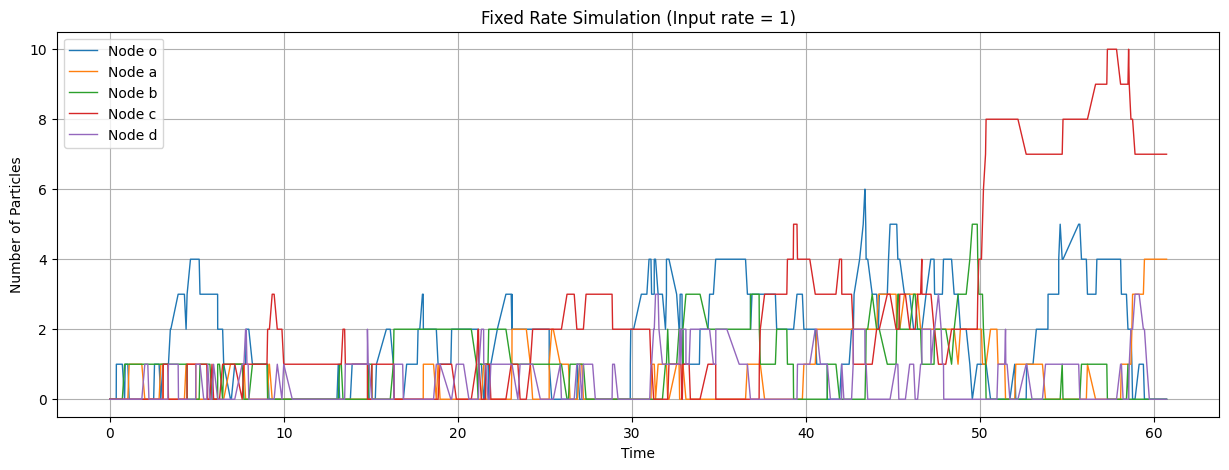

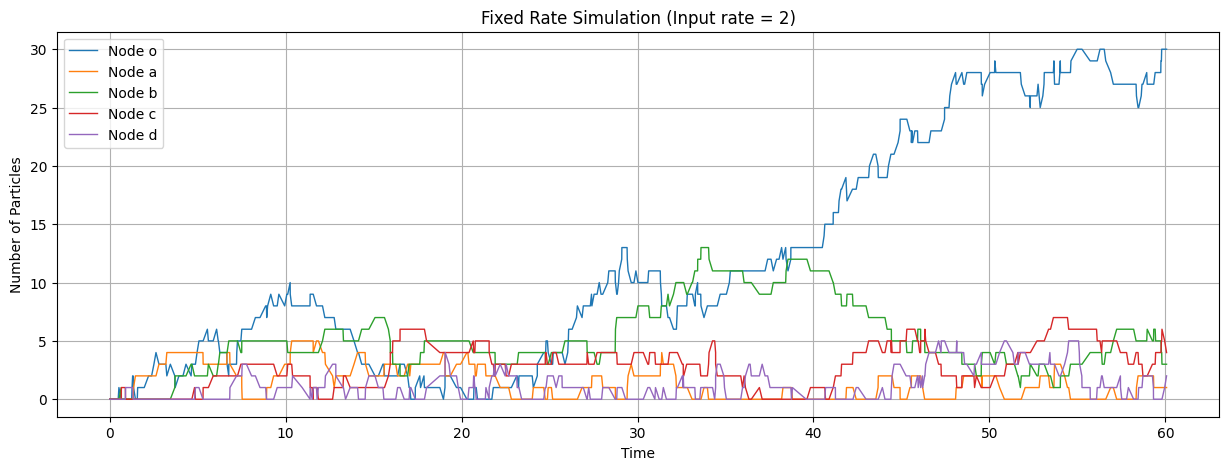

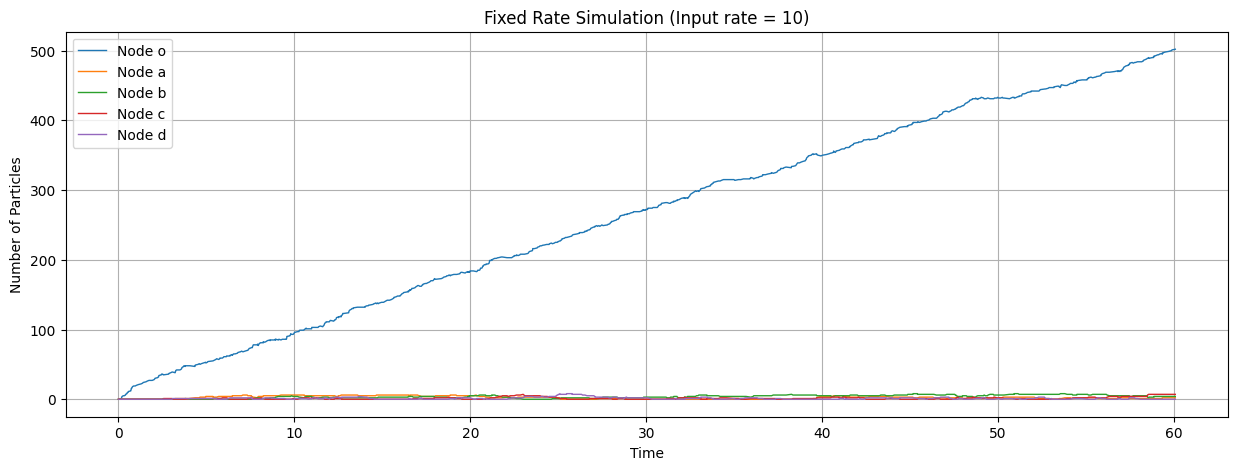

In [10]:

# Plotting function
def plot_fixed_rate_trajectories(transition_times, history, input_rate):
    """
    Plot the particle dynamics over time for fixed rates.
    """
    labels = ['o', 'a', 'b', 'c', 'd']
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(labels):
        plt.plot(transition_times, history[:, i], label=f"Node {label}", linewidth=1.0)

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Number of Particles")
    plt.title(f"Fixed Rate Simulation (Input rate = {input_rate})")
    plt.grid()
    plt.savefig(f"fixed_rate_simulation_{input_rate}.jpg")
    plt.show()

# Run Simulation for Multiple Input Rates
input_rates = [1, 2, 10]
time_units = 60

for rate in input_rates:
    history, transition_times = fixed_rate_simulation(time_units, rate)
    plot_fixed_rate_trajectories(transition_times, history, rate)

In [11]:
def simulate_fixed_rate(time_units, input_rate):
    """
    Simulate the system with a fixed input rate over a given time period.

    Parameters:
        time_units (float): Total simulation time.
        input_rate (float): Fixed rate at which particles are added to the system.

    Returns:
        hist_nodes (np.ndarray): Particle counts in each node over time.
        transition_times (list): Times at which events occurred.
    """
    # Initialize particle counts for all nodes (excluding dummy node)
    node_particles = np.zeros(num_nodes)

    # Initialize time tracking and particle history
    transition_times = [0]
    hist_nodes = [node_particles.copy()]  # Initial state

    while True:
        # Determine the next event
        start_node, total_rate = get_starting_node(node_particles, input_rate)
        
        # Calculate time to the next event
        t_next = transition_times[-1] + (-np.log(np.random.rand()) / total_rate)

        # Handle the event based on the selected starting node
        if start_node == num_nodes:  # Dummy node (external input)
            node_particles[0] += 1  # Add particle to node 'o'
        elif node_particles[start_node] == 0:  # Node has no particles
            pass  # Skip event
        elif start_node == num_nodes - 1:  # Node 'd' (absorbing state)
            node_particles[-1] -= 1  # Remove particle
        else:  # Regular node transition
            end_node = np.argwhere(Q_cum[start_node] > np.random.rand())[0][0]
            node_particles[start_node] -= 1
            node_particles[end_node] += 1

        # Record state and time
        transition_times.append(t_next)
        hist_nodes.append(node_particles.copy())

        # Stop simulation if the time limit is reached
        if t_next > time_units:
            break

    return np.array(hist_nodes), transition_times

In [12]:
def plot_fixed_rate_trajectories(transition_times, hist_nodes, input_rate):
    fig, ax = plt.subplots(figsize=(5,4), dpi=100)
    labels={0:'o',1:'a',2:'b',3:'c',4:'d'}
    for i in range(num_nodes): #only 5 nodes, excluding d'
        ax.plot(transition_times, hist_nodes[:, i], label=labels[i])

    ax.legend()
    plt.xlabel("Time units")
    plt.ylabel("Number of particles")
    plt.title("Input rate = {}".format(input_rate))
    # plt.savefig("fixed_rate_simulation_"+str(input_rate)+".pdf")
    plt.show()
    plt.close()

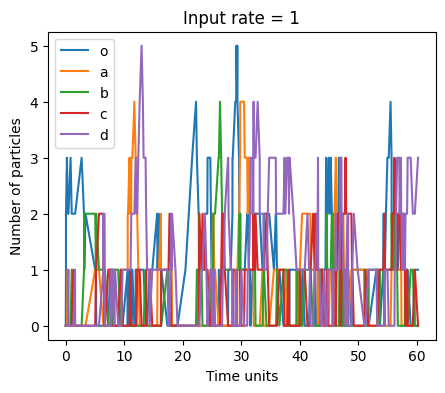

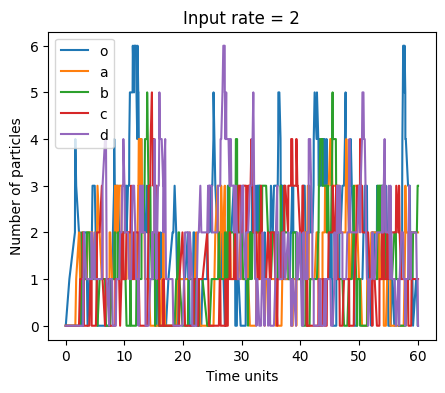

In [13]:
input_rates = [1, 2]

time_units =60
for input_rate in input_rates:
    hist_nodes, transition_times = simulate_fixed_rate(time_units, input_rate)
    plot_fixed_rate_trajectories(transition_times, hist_nodes, input_rate)